# CCE2502 Assignment II - Logistic Regression

## References
* https://hackernoon.com/how-to-plot-a-decision-boundary-for-machine-learning-algorithms-in-python-3o1n3w07
* https://www.youtube.com/watch?v=w5FhJdXWpBk
* https://bkenkel.com/psci8357/notes/04-higher-order.pdf
* https://github.com/bentrevett/gradient-descent/blob/master/3%20-%20Binary%20Logistic%20Regression%20from%20Scratch.ipynb
* https://www.quora.com/How-can-Neural-network-deal-with-non-linear-data
* https://realpython.com/python-csv/
* Fundamentals of Machine Learning for Predictive Data Analytics
* https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [49]:
# import useful packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import csv

from IPython.display            import IFrame
from matplotlib.colors          import ListedColormap
from sklearn.preprocessing      import PolynomialFeatures
from sklearn.neural_network     import MLPClassifier
from sklearn.model_selection    import train_test_split

___
# Provided Code

Year 2023-2024 - Semester II
Adrian Muscat, 2024

In [50]:
# Do not carry out any changes to the code in this cell

def lr_loss_function(y_target,y_predicted):
    """
    y_target: actual gold labels (vector of size(m,))
    y_predicted : predicted probabilities for positive class (vector of size (m,))
    returns categorical cross entropy loss
    """
    m=y_target.shape[0]
    L = -(y_target*np.log(y_predicted) + (1-y_target)*np.log(1-y_predicted)).sum()/m
    return L


def predict_y_prob(W,D):
    """
    W is the weight vector [[w_0],[w_1],[w_2],...] of size [N+1,1]
    where N is number of features, excluding bias
    D is the feature matrix [m,N] where m is the number of examples
    return a vector of size (m,1)
    """
    m = D.shape[0]
    bias = np.ones([m,1], dtype=float)
    X = np.concatenate((bias,D),axis=1)
    z = np.matmul(W.T,X.T)
    y = 1/(1+np.exp(-z))
    #
    return y.T

def get_accuracy(W,X,y):
    """
    W is the weight vector [[w_0],[w_1],[w_2],...] of size [N+1,1]
    where N is number of features, excluding bias
    X is the feature matrix [m,N] where m is the number of examples
    y is the gold label vector of size (m,)
    Computes and returns the accuracy in predicting the positive class and returns a scalar
    """
    Y_pred = (predict_y_prob(W,X)>=0.5).astype(int)
    #
    return (Y_pred.ravel()==y).astype(int).sum()/y.shape[0]

def display_results(model):
    #
    history_train_loss = model['history']['train_loss']
    history_val_loss = model['history']['val_loss']
    t=range(len(history_train_loss))
    p1, p2 = plt.plot(t,history_train_loss,'b',t,history_val_loss,'r')
    plt.legend([p1,p2], ['Train loss','Val loss'])
    #
    print('train acc : ', model['train_acc'])
    print('val acc   : ', model['val_acc'])
    #
    print('Weights : ', model['weights'].ravel())
    return 0

# Use this function for plotting datasets as scatter graphs
def data_scatter_plot(X,y):
    """
    Plots a scatter graph for a 2-D dataset
    X : Feature numpy array of size (m,N), 
            m=number of examples (rows)
            N = number of features (columns)
            If N>2, first two features taken in consideration
    y : Output label numpy array of size (m,1) or (m,)
    """
    mk ={0:'or', 1:'ob'}
    plt.plot(X[:,0][y[:]==0] , X[:,1][y[:]==0], mk[0])
    plt.plot(X[:,0][y[:]==1] , X[:,1][y[:]==1], mk[1])

___
# Gradient Descent Calculation

In [51]:
def gradient_step(W, X, t, y_hat, alpha=0.1, phi=0.1):
    """
    Performs one gradient descent step using all of the data points
    W (ndarray)             : weights vector
    X (ndarray)             : input features
    t (ndarray)             : actual output values
    y_hat (ndarray)         : predicted output values
    alpha (float)           : learning rate
    phi (float)             : regularization constant
    """

    m = t.shape[0] 
    N = X.shape[1]
    two_m = (m*2)

    y_der = t - y_hat

    # ---------------------------- Calculate the Summation of Dot Product
    errorDelta = np.matmul(X.T, y_der)

    # ---------------------------- Case k = 0
    W[0] += (alpha/two_m) * np.sum(y_der);

    # ---------------------------- Case k != 0
    for k in range(1, N+1):            
        W[k] += (alpha/two_m) * errorDelta[k-1] + 2*alpha*phi*W[k]

    return W

___
## Provided Train Model Function

In [52]:

# Gradient Descent algorithm that learns the model parameters
# The update equations require the partial derivatives of the loss function
# with respect to the weights or parameter of the model
#
def lr_train_model(X_data, 
                   y_data, 
                   reshuffle = 'yes',
                   split_frac=0.8, 
                   init_weights=0.00001, 
                   no_iterations=2000,
                   alpha = 0.001,
                   phi = 0.001):
    """
    X_data : data feature matrix (including bias x_0 = 1.0)
    y_data : data output values
    split_frac : data split fraction, we require the split to compute validation mse
        if split_frac = -1 (or negative), then dataset is not split and train and val portions are the same
    init_weights : initial weights (all same value)
        if init_weights = -1 (or negative), then random weights are chosen
    alpha : learning rate
    phi : regularisation constant
    W : weights vector
    """
    #
    idx = np.arange(0, y_data.shape[0])
    if reshuffle == 'yes':
        np.random.shuffle(idx)
    X_data = np.copy(X_data[idx])
    y_data = np.copy(y_data[idx])
    #
    if split_frac < 0.0:
        y_train, y_val, X_train, X_val = y_data, y_data, X_data, X_data
    else:
        split = int(y_data.shape[0]*split_frac)
        y_train, y_val, X_train, X_val  = y_data[0:split], y_data[split:], X_data[0:split], X_data[split:]
    #
    N = X_data.shape[1] # number of features
    print("Number of input features :",N)
    if init_weights < 0.0:
        W = 0.5*(np.random.rand((N+1))-0.5).reshape(N+1,1)
    else:
        W = np.full((N+1,1), init_weights) # initialise weight vectors to the same value
    print("Initial Weights:",W)
    m=y_train.shape[0]
    history_loss=[]
    history_val_loss=[]
    #
    for itr in range(no_iterations):
        y_pred_pr = predict_y_prob(W,X_train).ravel()
        loss = lr_loss_function(y_train,y_pred_pr)
        history_loss.append(loss)
        history_val_loss.append(lr_loss_function(y_val,predict_y_prob(W,X_val).ravel()))
        #
        #
        #######################################################################
        w = gradient_step(W, X_train, y_train, y_pred_pr, alpha, phi)
        #######################################################################
    #
    #
    return {'weights':W, 
            'history':{'train_loss':history_loss,
                                    'val_loss':history_val_loss},
            'train_acc':get_accuracy(W,X_train,y_train),
            'val_acc':get_accuracy(W,X_val,y_val)}

___
# TASK 1

## 1 - Function Definitions
Below are the functions used in this section


In [53]:
def read_csv(csv_file):
    """
    Load data from a CSV file and return the features (X1, X2) and the target variable (y).

    Parameters:
    - csv_file: Path to the CSV file.

    Returns:
    - X1    : Feature 1 array.
    - X2    : Feature 2 array.
    - y     : Target variable array.
    """
    X1, X2, y = [], [], []
    with open(csv_file, 'r') as file:

        # ------------------- Read CSV & Ignore the next line
        csv_read = csv.reader(file);  next(csv_read)
        for row in csv_read:
            X1.append   (float(row[0]))
            X2.append   (float(row[1]))
            y.append    (float(row[2]))

    return np.array(X1), np.array(X2), np.array(y)

In [54]:
def Plot_Boundry_Line(X, y, weights):
    """
    Plots the decision boundary for a logistic regression model.
    
    Parameters:
        X (numpy array): Feature matrix of size (m, n), where m is the number of examples and n is the number of features.
        y (numpy array): Target labels of size (m,).
        weights (numpy array): Model weights of size (n+1,).
    """
    # Calculate the decision boundary for multiple features
    decision_boundary_x = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]), 100)
    
    if X.shape[1] == 2:  # For 2 features, calculate decision boundary as before
        decision_boundary_y = -(weights[0] + weights[1] * decision_boundary_x) / weights[2]
    else:  # For more than 2 features, calculate decision boundary using the hyperplane equation
        decision_boundary_y = -(weights[0] + np.dot(weights[1:], decision_boundary_x.T)) / weights[-1]
    
    # Plot the scatter plot of data points
    data_scatter_plot(X, y)
    
    # Plot the decision boundary
    plt.plot(decision_boundary_x, decision_boundary_y, color='forestgreen', label='Decision Boundary')
    
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Scatter plot with Decision Boundary')
    plt.legend()
    plt.grid(True)
    plt.show()

## 1.A - Read CSV

In [55]:
X1_basic, X2_basic, y_basic = read_csv('binary_classification_basic.csv')
X_basic = np.column_stack((X1_basic, X2_basic))

## 1.B - Plot Scatter Plot

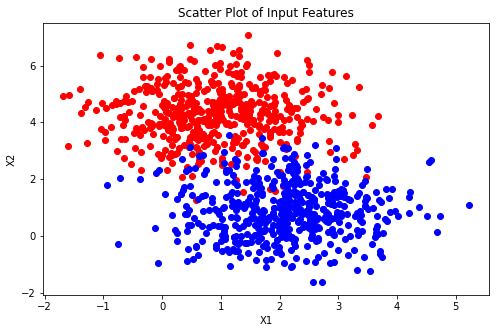

In [56]:
plt.figure(figsize=(8, 5), facecolor='white')
data_scatter_plot(X_basic, y_basic)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Input Features')
plt.show()

## 1.C - Partial Derivative

### Original Equation

$$L(\textbf{w}) = -\frac{1}{2m} \left[ \sum_{i=1}^{m} t^i \log \bigg(y(x^i, \textbf{w})\bigg) + (1 - t^i) \log\bigg(1 - y(x^i,\textbf{w})\bigg) \right] + \frac{\phi}{2} \sum_{j=1}^{N} w_j^2$$

### Partial Derivative in terms of $\textbf{w}$

$$
\frac{\partial ( L(\textbf{w}))}{\partial w_k} =

    \frac{1}{2m}

    \left[

        \sum_{i=1}^{m}
            {
                \bigg(t^i - y(x^i,\textbf{w}) \bigg)
                \cdot
                \bigg(x^i_k\bigg)

            }

    \right]
    +
    {
        2 \phi w_k
    }
$$


## 1.D - Implemtation of gradient Descent

```python
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
1  y_der = t - y_hat
2  
3  errorDelta = np.matmul(X.T, y_der)
4
5  W[0] += (alpha/two_m) * np.sum(y_der);                                           
6                                                                                   
7  for k in range(1, N+1):                                                          
8      W[k] += (alpha/two_m) * errorDelta[k-1] + 2*alpha*phi*W[k]                   
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
```
The above pseudo code performs the two calculations that are listed at the last page of the workings pdf.
In otherwords it performs the below calculation

$$ \textbf{w}_k =  \textbf{w}_k + \left[\frac{\alpha}{2m}
    \left[\sum_{i=1}^{m}{\bigg(t^i - \hat {y} \bigg)\cdot\bigg(x^k_i\bigg)}\right]
        +{2 \phi w_k \alpha}\right]$$

In order to work out the dot-product and summation, the code makes use of a matrix multiplication.

Since $\textbf{t}$, $\hat{\textbf{y}}$ and $\textbf{x}_k$ are vectors of the smae length, we can perform the following operations

$\textbf{t} - \hat{\textbf{y}}$ would result in a vector of the same length.

and by transposing $\textbf{x}$ we can perform a matrix multiplication which would both serve to multiply and sum the terms. Hence:

$$\sum_{i=1}^{m}{\bigg(t^i - \hat {y} \bigg)\cdot\bigg(x^i_k\bigg)} = \textbf{X}^T(\textbf{T} - \hat{\textbf{Y}})$$


## 1.E Training & Displaying the Results

Number of input features : 2
Initial Weights: [[1.e-05]
 [1.e-05]
 [1.e-05]]
train acc :  0.945
val acc   :  0.965
Weights :  [ 2.52602633  1.58437206 -2.02327428]


0

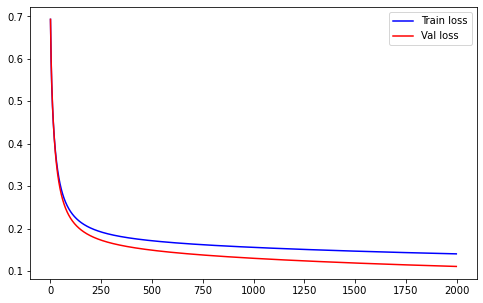

In [57]:
result_basic = lr_train_model(
    X_data  = X_basic,      # Pass the features and samples
    y_data  = y_basic,      # Pass Expected results
    alpha   = 0.1,
)

plt.figure(figsize=(8, 5), facecolor='white')
display_results(result_basic)

# 1.F Displaying the Decision Boundary

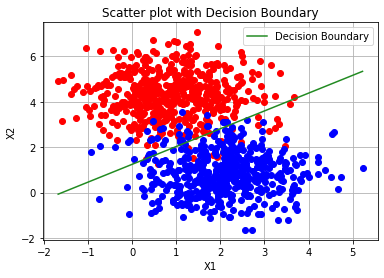

In [58]:
Plot_Boundry_Line(X_basic, y_basic, result_basic['weights'])

___
# TASK 2

## 2 - Function declarations

In [59]:
def z_normalize(X):
    """
    Z-score normalization of a dataset.

    Parameters:
    X (numpy.ndarray): Input data, where each row represents a sample and each column represents a feature.

    Returns:
    numpy.ndarray: Normalized data, where each feature is standardized to have a mean of 0 and a standard deviation of 1.
    """
    mean    = np.mean   (X, axis=0)
    std_dev = np.std    (X, axis=0)

    # Z-score normalization
    return (X - mean) / std_dev


## 2.A - Reading CSV

In [60]:
X1_advanced, X2_advanced, y_advanced = read_csv('binary_classification_advanced.csv')
X_advanced = np.column_stack((X1_advanced, X2_advanced))

X_advanced = z_normalize(X_advanced)

## 2.B - Scatter Plot

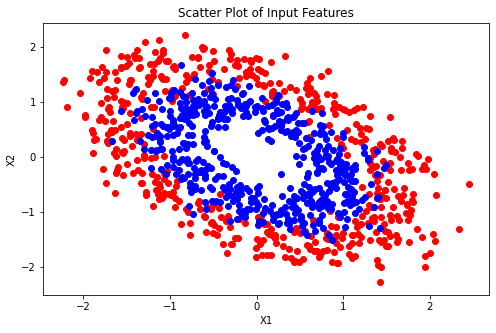

In [61]:
plt.figure(figsize=(8, 5), facecolor='white')
data_scatter_plot(X_advanced, y_advanced)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Scatter Plot of Input Features')
plt.show()

## 2.C -  Training & Plotting the results

Number of input features : 2
Initial Weights: [[1.e-05]
 [1.e-05]
 [1.e-05]]
train acc :  0.5575
val acc   :  0.545
Weights :  [ 0.02043699 -0.03703856 -0.01415217]


0

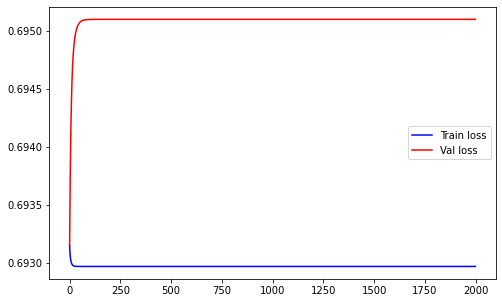

In [62]:
result_advanced = lr_train_model(
    X_data  = X_advanced,      # Pass the features and samples
    y_data  = y_advanced,      # Pass Expected results
    alpha   = 1,
)
# Display the results
plt.figure(figsize=(8, 5), facecolor='white')
display_results(result_advanced)

### 2.C.1 -  Plotting the Desicion Boundry

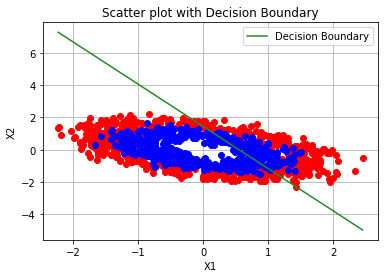

In [63]:
Plot_Boundry_Line(X_advanced, y_advanced, result_advanced['weights'])

### Discussing the Results

As can be seen from the output of the results, the accuracy of the model is much lower then from the previous "basic dataset".

This is mostly due to the fact that the linear boundry is not really compatible with the circular nature of the "advanced dataset". In other words one possible way of increasing the accuracy is to use a curved boundry.


## 2.D - Higher Order Terms

## Creating Additional Features

Number of input features : 10
Initial Weights: [[1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]
 [1.e-05]]
train acc :  0.81875
val acc   :  0.845
Weights :  [-0.87191257  0.16829518  0.11526621 -1.47591813 -1.39960244 -0.14055864
  0.0132533  -1.29727419 -1.2408677  -0.2409393   0.06479363]


0

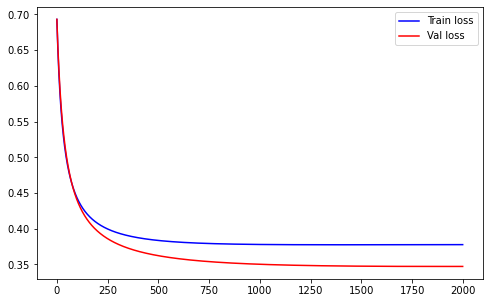

In [64]:
degree = 5
m, n = X_advanced.shape
X_Ho = X_advanced.copy()

for d in range(2, degree + 1): 
        for i in range(n):
            X_Ho = np.column_stack((X_Ho, X_advanced[:, i] ** d))

X_Ho = z_normalize(X_Ho)


# Train the logistic regression model
result_high_order = lr_train_model( 
    X_data  = X_Ho,      # Pass the features and samples
    y_data  = y_advanced,      # Pass Expected results
    alpha   = 0.1,
)

plt.figure(figsize=(8, 5), facecolor='white')
display_results(result_high_order)

Since the first plot resulted in a linear decision boundary, by adding higher order terms we are able to curve the boundary hence creating a non-linear border.  By adding higher-order terms we are effectively changing the model, the calculation below gives an example of what the higher-order terms are doing.

$$y=w_0​+w_1​x_1​+w_2​x_2​$$

$$y=w_0​+w_1​x_1​+w_2​x_2​+w_3​x_1^2​+w_4​x_2^2​$$

The second function would be best compared to that of a circular plot, hence it can be seen how the linear boundary from the first plot has now changed to the curved one of the second.

## By Scaling and Shifting

Number of input features : 2
Initial Weights: [[1.e-05]
 [1.e-05]
 [1.e-05]]
train acc :  0.8175
val acc   :  0.825
Weights :  [-0.71778581 -2.7553974  -2.62409148]


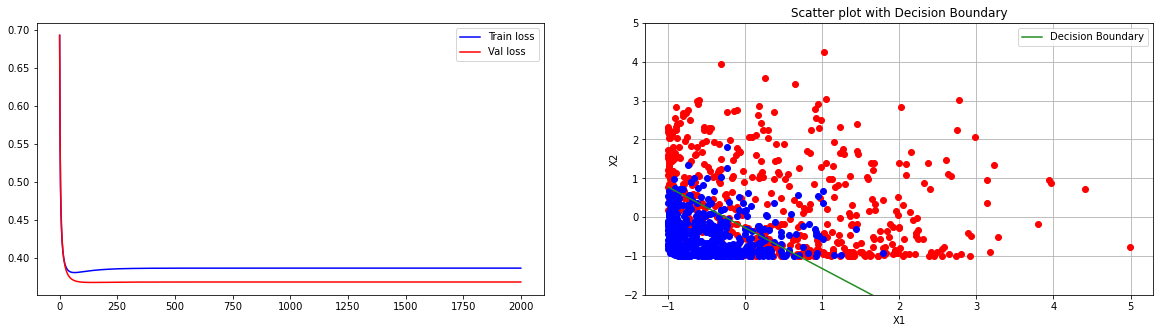

In [ ]:
X_advanced_centered = X_advanced**2

X_advanced_centered = z_normalize(X_advanced_centered)

result_advanced_scaled = lr_train_model(
    X_data  = X_advanced_centered,       # Pass the features and samples
    y_data  = y_advanced,                       # Pass Expected results
    alpha   = 2,
)
# Display the results

plt.figure(figsize=(20, 5), facecolor='white')
plt.subplot (1, 2, 1)
display_results(result_advanced_scaled)
plt.subplot (1, 2, 2)
plt.ylim(-2,5)
Plot_Boundry_Line(X_advanced_centered, y_advanced, result_advanced_scaled['weights'])

This is a different attempt to try and get a morea accurate decision boundry but this time still using the same linear boundry line. Although this may only work for datasets of a similare structure it is worth testing out. This implementation is a lot simpler to implement when compared to the higher order terms implementation, and does server to improve the accuracy of the model. That being, this model cannot be adjusted to the same degree as the higher-order terms one, and once again is not really applicable to other models.

___
# TASK 3

## 3.A - Non-Linearity and Neural Networks
A neural network as it's name explains makes use of connections and links between neurons, each of which processes and transfers data to other neurons, each time modifying the importance of the data. Through the process of trial and error it can refine these links, and so can fit complex problems/patterns. It is through this constant fine-tuning that the network can detect relationships between data types, which allows it to finally identify non-linear patterns.

## 3.B - Neural Network Implementation

In [ ]:
def plot_NN_Boundry(X, y, classifier):
    """
    Plots the decision boundary generated by a neural network classifier.

    Parameters:
        X (numpy array) : Feature matrix of size (m, 2), where m is the number of examples and 2 is the number of features.
        y (numpy array) : Target labels of size (m,).
        classifier      : Trained neural network classifier object capable of making predictions.

    Returns:
        None

    This function creates a meshgrid of points covering the range of the input data, 
    predicts the labels for all points in the meshgrid using the provided classifier, 
    and plots the decision boundary along with the data points.
    
    """
    # Create a meshgrid of points
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict the labels for all points in the meshgrid
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

    # Reshape the predictions into the meshgrid shape
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data points
    plt.figure(figsize=(8, 5), facecolor='white')
    plt.contourf(xx, yy, Z, alpha=0.3)
    data_scatter_plot(X,y)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Boundary (MLP)')
    plt.show()

Training accuracy: 0.92
Testing accuracy: 0.88


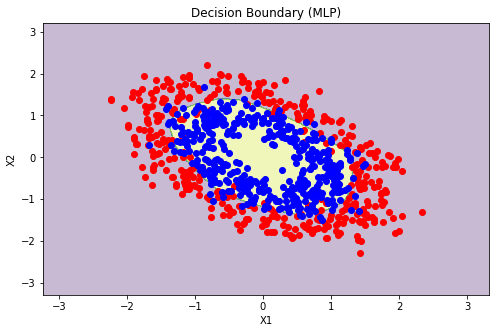

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_advanced, y_advanced, test_size=0.2)

# Initialize and train the MLP classifier
mlp = MLPClassifier (   hidden_layer_sizes  = (100, 100), 
                        activation          = 'relu', 
                        solver              = 'adam',
                        max_iter            = 200,
                        random_state        = 100,
                        learning_rate       = 'invscaling'
                    )
mlp.fit(X_train, y_train)

# Calculate accuracy on training and testing sets
train_accuracy = mlp.score(X_train, y_train)
test_accuracy = mlp.score(X_test, y_test)
print("Training accuracy:", train_accuracy)
print("Testing accuracy:", test_accuracy)


# Plot decision boundary on training data
plot_NN_Boundry(X_train, y_train, mlp)

## 3.B Analysing the results
Here I will be explaining my choices in parameters,

* Firstly for the solver using lbfgs resulted in a higher accuracy but the boundry line was overfitted hence either adam or sgd are best fitting and adam was chosen as this has a faster run time

* Hidden Layers did not seem to have much effect on the model hence they were set close to the default

* The number of iterations was set to 200 iterations as this is the default and works well

* The learning rate is set to invscaling as this reduces the value of alpha each iteration 

## 3.C Ways to accurately judge the performance

The first way is to check the consistency of the Neural network results, over multiple run-throughs of the data. If the results are consistent then this is likely to indicate that the network is performing as expected. If the network results in constant outliers, then this may be due to errors in the implementation


Another solution is through visual inspection. In this assignment, the decision boundary is plotted in order to confirm visually if the generated models are working correctly. The same can be done with Neural Networks, by displaying visually the decision boundary that a network is generating one can reach conclusions on the performance of the neural network. Although this may not be feasible with larger datasets.


In this run example, I have taken the liberty of plotting the decision boundary and through that, we can see the almost smooth curve that the neural network has created. This shows that the boundary line generated by the neural network is closely following the dataset's general form showing how it is working properly.